# 7. 인물사진 만들기
---

## 목차
### 1. 개요
    1.1 들어가기에 앞서
    1.2 루브릭 평가기준
### 2. 프로젝트: 셸로우 포커스 (인물)
    2.1 인물1
    2.2 인물2 
    2.3 인물 뒷모습
    2.4 인물과 그림자
    2.5 여러 인물
    2.6 인물 캐릭터
### 3. 프로젝트: 셸로우 포커스 (고양이)
    3.1 고양이
    3.2 고양이 뒷모습
    3.3 옷입은 고양이
### 4. 프로젝트: 크로마키 합성
    4.1 인물
    4.2 고양이
### 5. 결론
    5.1 결론
    5.2 참조
    5.3 회고
 
 
  3.1 사진에서의 문제점 찾기
  
3.2 해결방법 제안

---

## 1. 개요
### 1.1 들어가기에 앞서
---
#### 학습 목표
- 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.

___ 

#### 노드 Questions
![인스턴스](https://d3s0tskafalll9.cloudfront.net/media/images/E-14-5.max-800x600_YNvIU7P.png)

##### Q1. 위 이미지의 MS COCO 데이터셋 라벨은 인스턴스 세그멘테이션이라고 부를 수 있을까요?
- 인스턴스 세그멘테이션이라 부를 수 있다. 여러 사람이 사람이라는 한 클래스내에서 각각의 개체가 구분되어 있기 때문이다.

##### Q2. 인스턴스 세그멘테이션 데이터셋과 라벨이 존재하면 시맨틱 세그멘테이션을 학습시킬 수 있을까요?
- 인스턴스의 id 뿐만 아니라, 클래스 라벨도 존재해야 학습이 가능하다. 대부분의 데이터셋은 인스턴스 라벨이 있는 경우 클래스 라벨도 함께 존재한다.

##### Q3. DeepLab에서 atrous convolution을 사용한 이유가 무엇인가요?
- 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서도, field of view (한 픽셀이 볼 수 있는 영역) 를 크게 가져가 receptive field를 넓게 사용할 수 있기 때문에 DeepLab에서 적극 활용한다.

##### Q4. Depthwise separable convolution은 어디서 처음 사용한 것 일까요? 왜 이 구조가 효율적일까요?
- Xception 에서 제안됨. 3x3 conv layer 의 receptive field를 1/9 수준의 파라미터로 구현할 수 있기 때문에 효율적이다.



---

#### 이론 정리
- 파사계 심도(DOF): 한 사진의 초점이 맞은 것으로 인식되는 범위의 한계를 말한다.

- 아웃포커싱 = 파사계 심도 = 셸로우 포커스 (같은 의미)

- 핸드폰 인물사진 모드는 화각이 다른 두 렌즈를 사용한다

- 광각렌즈(일반)에서는 배경을 촬영, 망원 렌즈에서는 인물을 촬영한 뒷배경을 흐리게 처리한 후 망원 렌즈의 인물과 적절히 합성

- 이미지 세그멘테이션(image segmentation): 모든 픽셀에 라벨을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정하는 작업

- 시맨틱 세그멘테이션(semantic segmentation): 이미지 내에 있는 객체들을 물리적 단위로 분류하는 작업

- 인스턴스 세그멘테이션(Instance segmentation): 피사체 개개인별로 다른 라벨을 가지게 하는 작업(여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것)

- 세그멘테이션 문제는 FCN, SegNet, U-net등 많은 모델이 사용되지만, 이번 프로젝트에서는 성능이 매우 좋은 DeepLab 이라는 세그멘테이션 모델을 이용

____

## 1.2 루브릭 평가기준
평가문항|상세기준
-|-
1. 인물모드 사진을 성공적으로 제작하였다.| 아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다. | 인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다. | 추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.

----

## 2. 프로젝트: 셸로우 포커스(인물)
배경사진 준비 > 시맨틱 세그멘테이션으로 피사체와 배경 분리 > 블러링 기술로 배경 흐리게 조정 > 피사체를 배경의 원래 위치에 합성


### 2.1 인물1

In [1]:
# 필요한 모듈 import 하기

import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

- urllib는 웹에서 데이터를 다운로드할 때 사용

- cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요

- pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리

> 아직 시맨틱 세그멘테이션 모델을 직접 만들기 어려우니 준비된 모델 사용

(795, 775, 3)


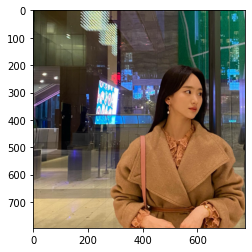

In [2]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f096cb68d00>)

- PixelLib에서 제공하는 모델 다운로드

In [4]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

- PixelLib로 사용할 세그멘테이션 모델을 생성

In [5]:
segvalues, output = model.segmentAsPascalvoc(img_path)

- 모델에 이미지 입력

- segmentAsPascalvoc는 PASCAL VOC 데이터로 학습된 모델을 이용한다는 의미

> 모델마다 학습시킨 데이터에 따라 결과값이 달라지므로 어떤 데이터를 학습한 지 파악하는 것은 매우 중요한 사안

In [6]:
# PASCAL VOC 데이터의 라벨 종류

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 총 21개의 클래스가 있다.

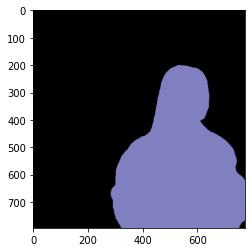

In [7]:
plt.imshow(output)
plt.show()

- 사람의 영역만 출력됨
- 세그멘테이션이 된 결과가  각각 다른 색상으로 담겨져 있음

In [8]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

- segvalues에는 class_ids와 masks가 있다.
- class_ids의 배열을 통해 어떤 물체가 담겨 있는지 알 수 있다.

In [9]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [10]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- output에 어떤 색상으로 나타난 지 확인하는 코드
- PixelLib에 따르면 위와 같은 색을 사용했음

> 코드를 이해하지 않아도 된다.

In [11]:
colormap[15]

array([192, 128, 128])

- 사람의 색상

(795, 775)


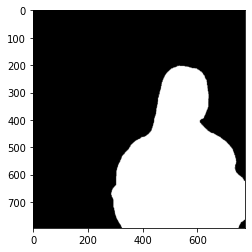

In [12]:
seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

- BGR 순서로 채널 배치가 되어 있는 output 이미지를 위와 같이 바꾸어줌
- 3채널 가졌던 원본과는 다르게 채널 정보가 사라짐

In [13]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

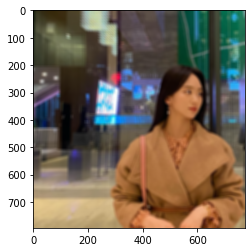

In [14]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐려진 이미지에서 세그멘테이션 마스크를 이용해 배경만 추출
- bitwise_not 함수를 이용하면 이미지가 반전
- 배경이 0, 사람이 255 였던 것을 bitwise_not 함수를 이용하면 배경은 255, 사람은 0이 된다.

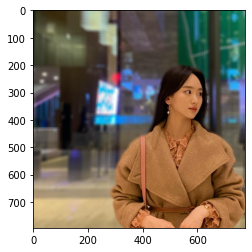

In [16]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 흐려진 배경 이미지와 원본의 사람 이미지를 합침
- 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용
- np.where(조건,True,False)문을 사용

> 배경 블러처리가 잘 된 케이스

---

### 2.2 인물2

(810, 585, 3)


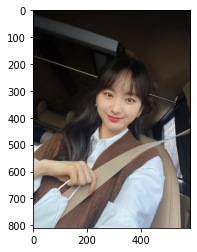

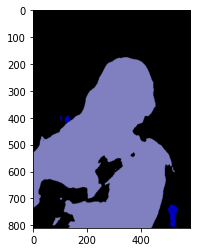

background
chair
person
(810, 585)


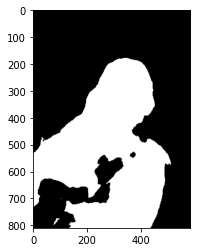

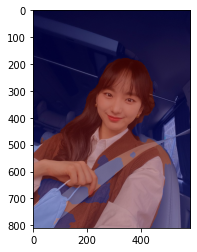

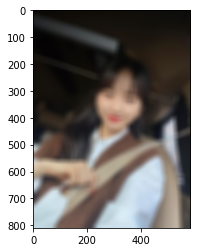

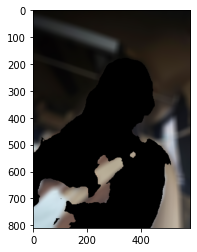

In [17]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image2.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[15]

img_show = img_orig.copy()

seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 배경과 인물 경계로 이어진 차량 안전 벨트로 인해 블러처리가 잘 되지 않음

---

### 2.3 인물 뒷모습

(252, 200, 3)


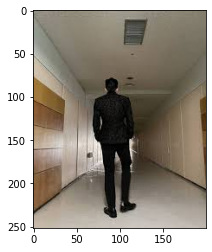

background
person
(252, 200)


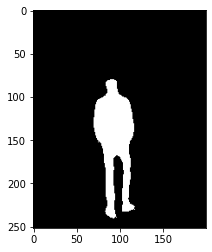

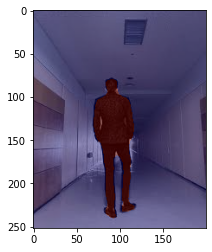

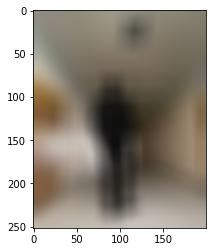

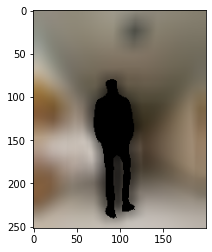

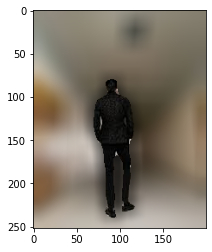

In [18]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image3.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[15]

img_show = img_orig.copy()

seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 블러처리가 잘 된 것 같으나, 아주 미세한 빛이 비추는 부분은 블러처리가 잘 되지 않은 것 같음

---

### 2.4 인물과 그림자

(538, 640, 3)


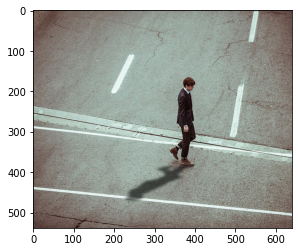

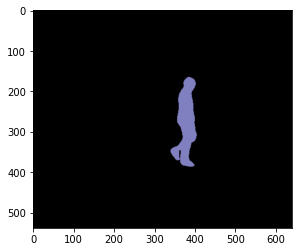

background
person
(538, 640)


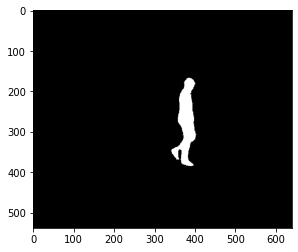

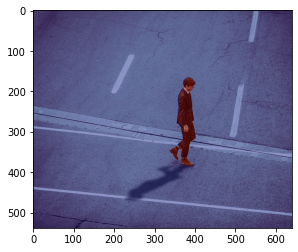

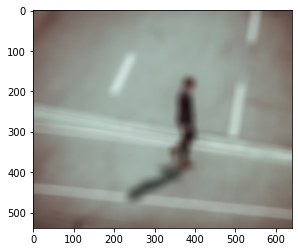

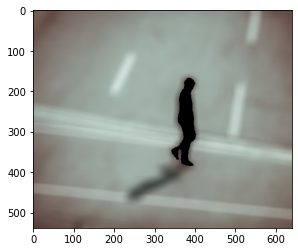

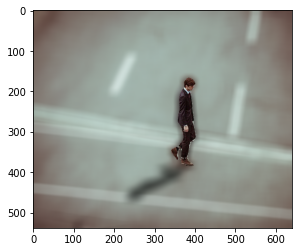

In [19]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image0.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[15]

img_show = img_orig.copy()

seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 인물의 그림자도 배경으로 인식되어 블러처리가 잘 되었음

---

### 2.5 여러 인물

(183, 275, 3)


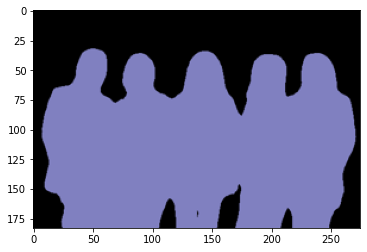

background
person
(183, 275)


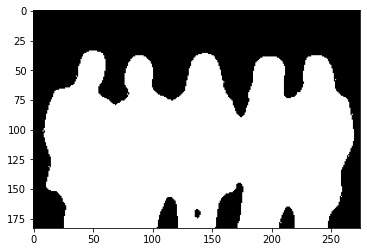

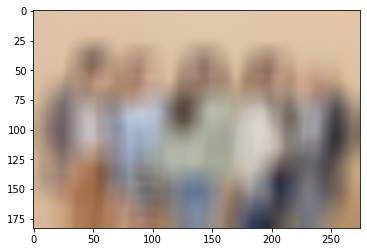

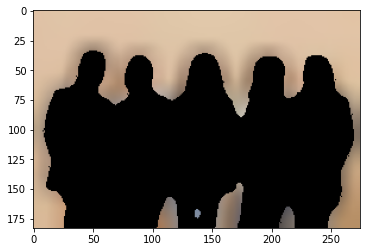

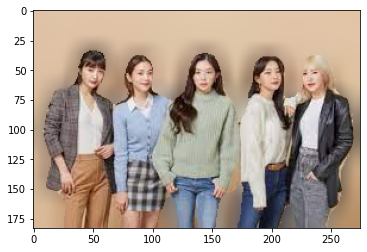

In [20]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image4.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[15]

img_show = img_orig.copy()

seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 여러 인물을 인식하는 것에는 문제가 없었으나 전체적으로 매끄럽게 블러처리 되지 않았고, 제일 우측의 있는 인물의 머리색깔이 배경 색깔과 겹쳐 인물의 머리카락까지 블러처리가 되었음

---

### 2.6 인물 캐릭터

(389, 264, 3)


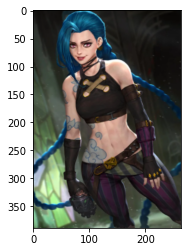

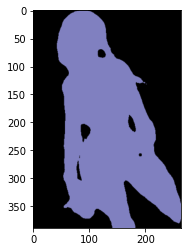

background
person
(389, 264)


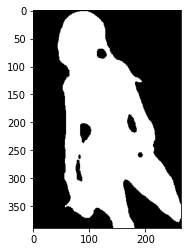

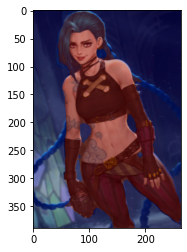

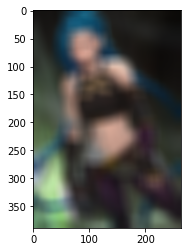

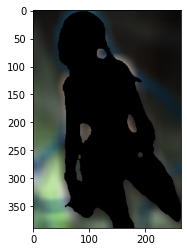

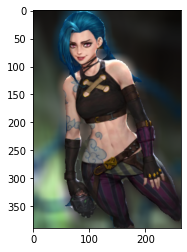

In [21]:

# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image6.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[15]

img_show = img_orig.copy()

seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 인물 캐릭터의 배경도 블러처리가 잘 되었으나, 연결되지 않은 머리카락까지 배경으로 인식하여 블러처리 되었음

---

## 3. 프로젝트: 셸로우 포커스(고양이)


### 3.1 고양이

(492, 745, 3)


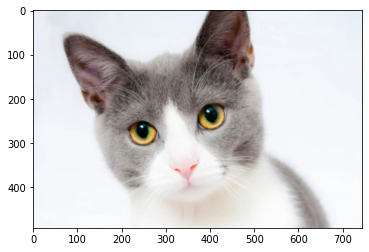

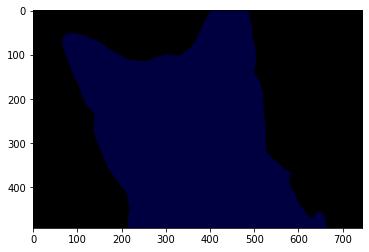

background
cat
(492, 745)


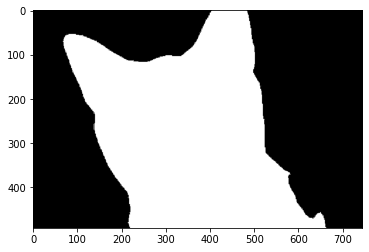

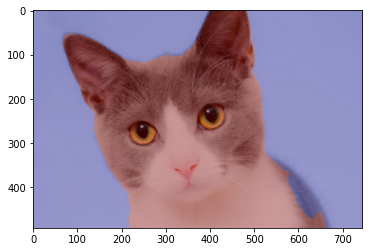

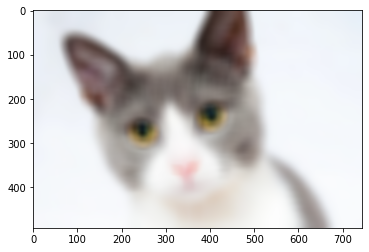

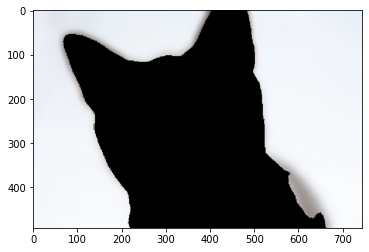

In [22]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat1.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[8]

img_show = img_orig.copy()

seg_color = (0,0,64)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 고양이의 색상을 나타내는 배열은 (0, 0, 64)이지만, BGR 순서로 채널 배치가 되어 있는 output 이미지를 RGB로 바꾸어준다.
- seg_color = (0,0,64)

> 고양이를 인식하는 것에는 문제가 없었으나, 약간의 블러처리가 된 고양이 사진을 불러와, 배경과 함께 고양이 몸통 일부분도 같이 블러처리 되었음

---

### 3.2 고양이 뒷모습

(506, 337, 3)


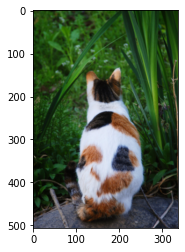

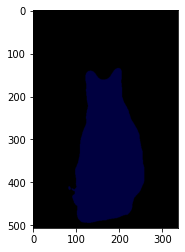

background
cat
(506, 337)


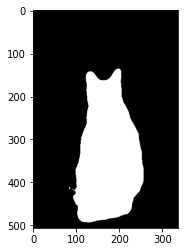

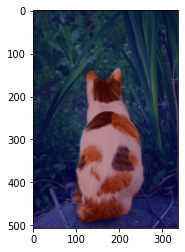

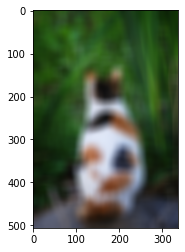

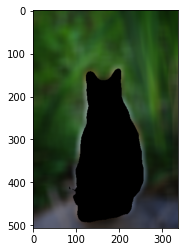

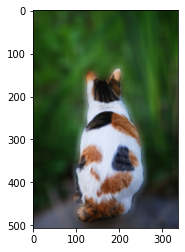

In [23]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[8]

img_show = img_orig.copy()

seg_color = (0,0,64)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 고양이 뒷모습의 배경은 블러처리가 잘 되었음

---

### 3.3 옷입은 고양이

(665, 668, 3)


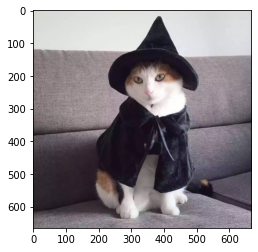

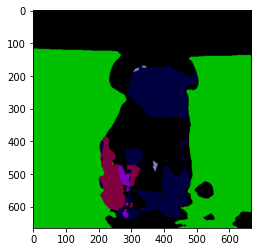

background
cat
dog
horse
person
sofa
(665, 668)


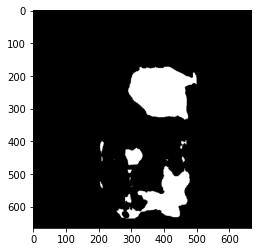

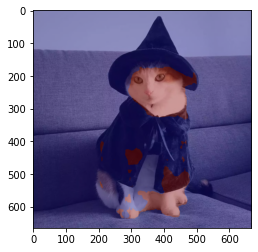

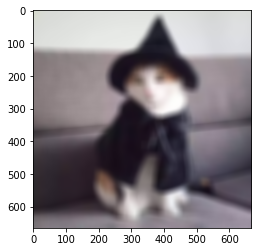

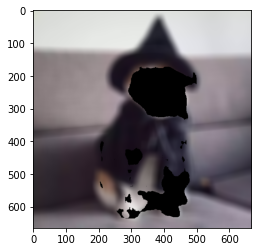

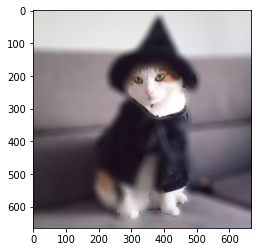

In [24]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat3.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[8]

img_show = img_orig.copy()

seg_color = (0,0,64)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

> 고양이의 얼굴과 몸통 일부분은 인식이 잘 되었으나, 고양이가 입은 옷은 통째로 배경과 함께 블러처리됨

---

## 4. 프로젝트: 크로마키 합성

---

### 4.1 인물

(422, 315, 3)


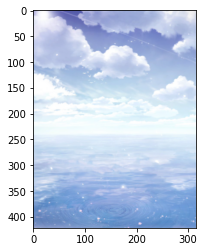

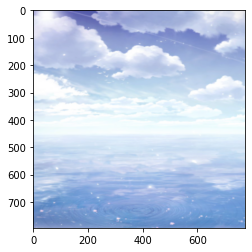

In [26]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image7.png'  
img_orig2 = cv2.imread(img_path) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

img_resize = cv2.resize(img_orig2,(775,795), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB))
plt.show()

- 합성할 배경 이미지 불러오기
- 합성할 인물 이미지와 동일한 크기로 이미지 리사이즈

(795, 775, 3)


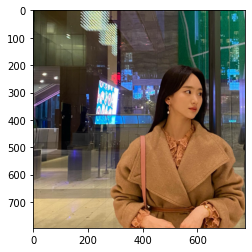

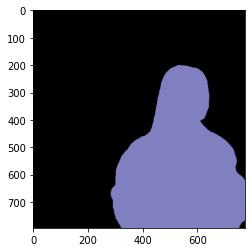

background
person
(795, 775)


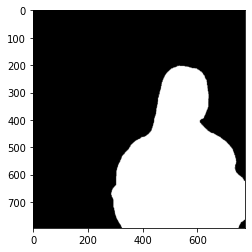

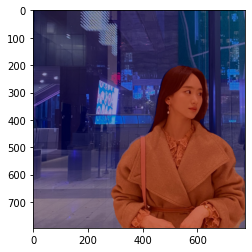

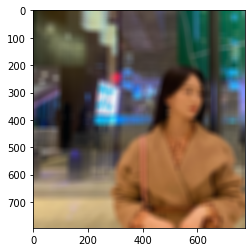

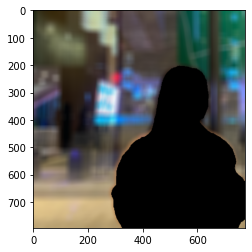

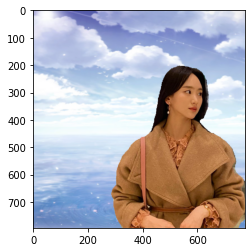

In [30]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[15]

img_show = img_orig.copy()

seg_color = (128,128,192)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_resize)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

### 4.2 고양이

(463, 287, 3)


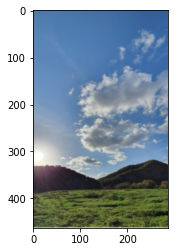

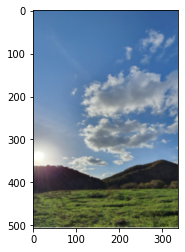

In [32]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image8.png'  
img_orig3 = cv2.imread(img_path) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

img_resize2 = cv2.resize(img_orig3,(337,506), interpolation=cv2.INTER_AREA)
plt.imshow(cv2.cvtColor(img_resize2, cv2.COLOR_BGR2RGB))
plt.show()

(506, 337, 3)


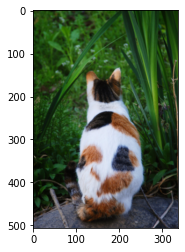

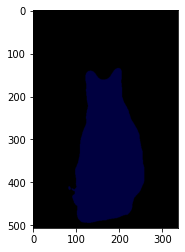

background
cat
(506, 337)


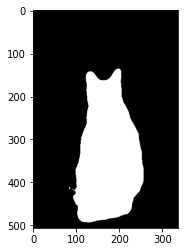

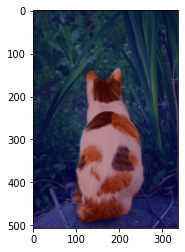

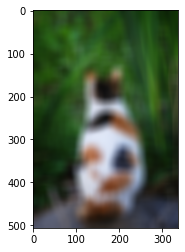

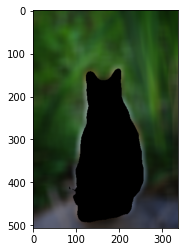

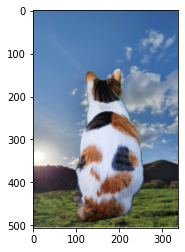

In [33]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat2.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

# PASCAL VOC 데이터의 라벨 종류

plt.imshow(output)
plt.show()

segvalues
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

colormap[8]

img_show = img_orig.copy()

seg_color = (0,0,64)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (25,25))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

img_concat = np.where(img_mask_color==255, img_orig, img_resize2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---

## 5. 결론
### 5.1 결론

---
### 문제점

#### 인물2의 문제점

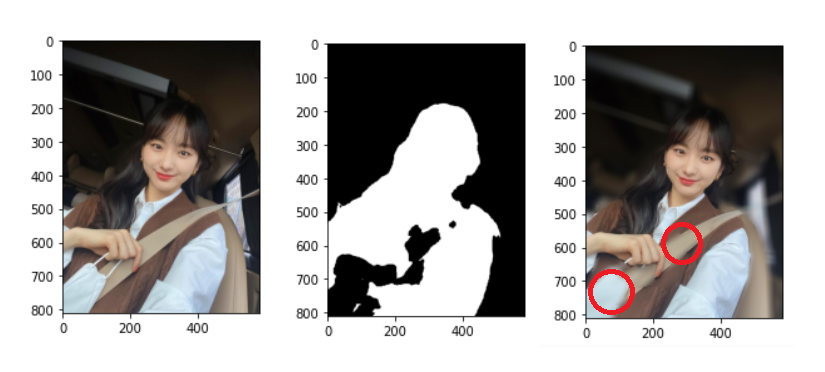

> 배경에서 피사체까지 이어지는 안전벨트가 피사체 내부에서도 블러처리 되는 문제점 발견

---



#### 인물 뒷모습의 문제점

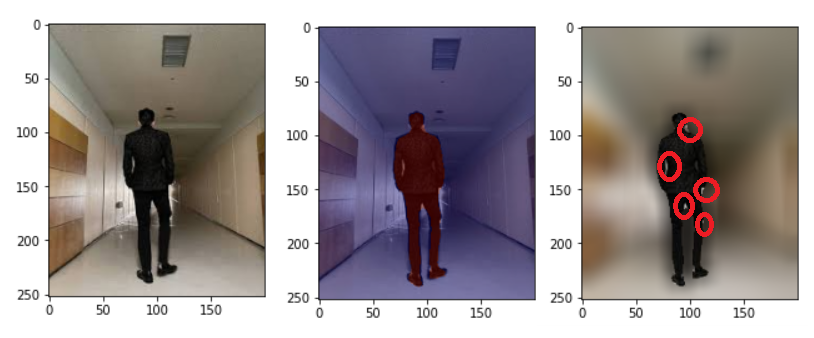

> 배경과 피사체 경계 사이에 비추는 불빛이 블러처리가 잘 되지 않는 문제점 발견

---

#### 여러 인물의 문제점

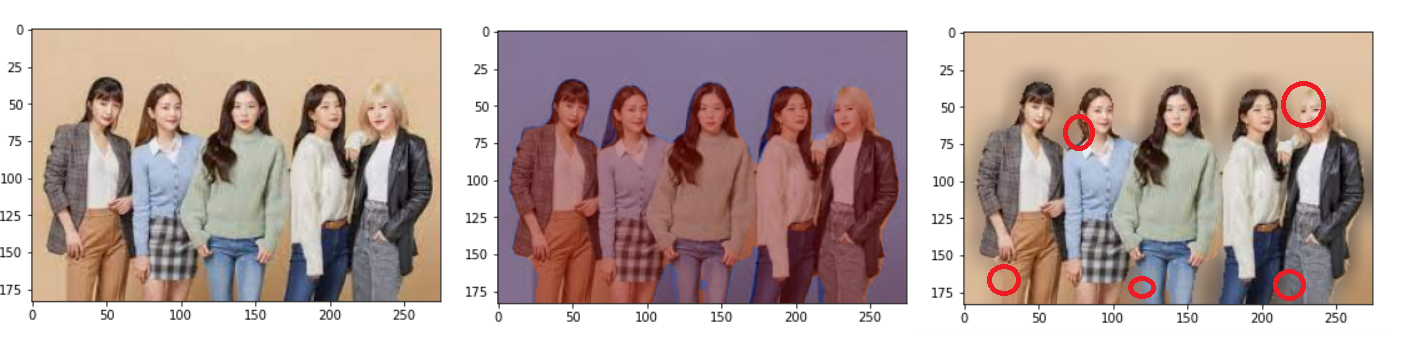

> 인물과 배경의 거리가 불확실하여 블러처리가 경계간에 불러처리가 잘 되지 않았음. 심지어 배경색깔과 비슷한 머리의 색상을 한 인물들의 경우 머리까지 블러처리 되는 문제점 발견


---

#### 인물 캐릭터의 문제점

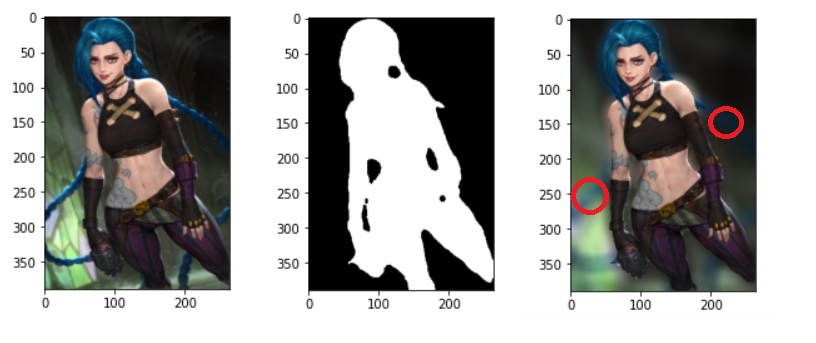

> 피사체가 실제 인물이 아닌 캐릭터 인물임에도 인식에는 문제가 없었으나, 캐릭터의 머리카락이 어깨 아래로 일부분 가려지기 시작한 순간 배경으로 인식되어 어깨 아래 머리카락도 블러처리 되는 문제점 발견

----

#### 고양이의 문제점

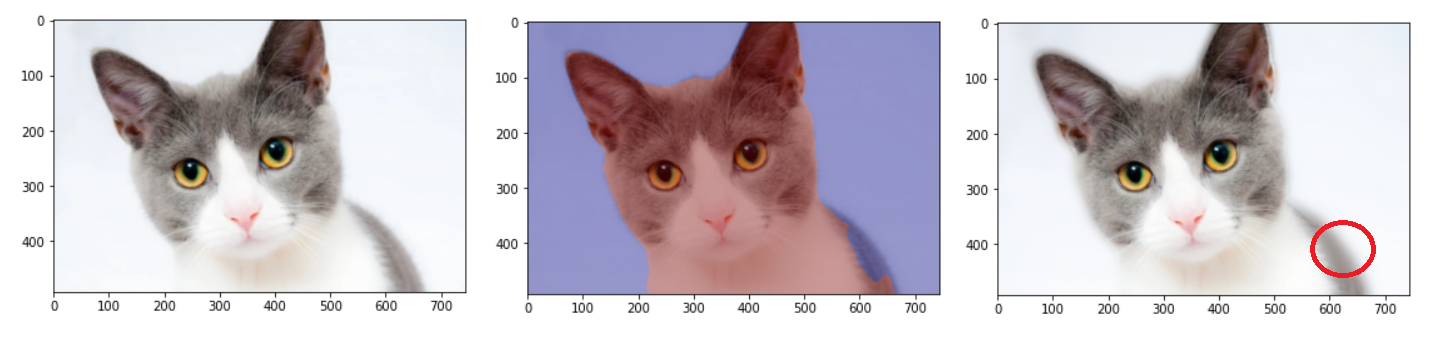

> 기존 원본 배경을 일부 블러처리된 배경을 사용해보았으나, 이미 블러처리된 부분은 끝까지 블러처리하는 문제점 발견.

---

#### 옷입은 고양이의 문제점

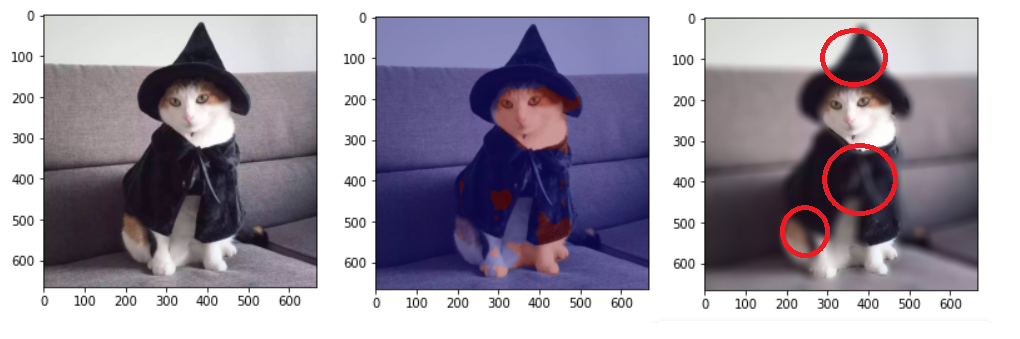

> 피사체가 인물일 경우와는 다르게 고양이가 옷을 입었을 때의 경우, 모자와 옷까지 블러처리 되는 문제점 발견

---

---

### 5.2 참조

- 이미지 세분화: https://doooob.tistory.com/79

- 세그멘테이션: https://velog.io/@dongho5041/%EB%94%A5%EB%9F%AC%EB%8B%9D-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%84%B8%EA%B7%B8%EB%A9%98%ED%85%8C%EC%9D%B4%EC%85%98Image-Segmentation

- 크로마키 합성: https://deep-learning-study.tistory.com/134

- 세그멘테이션 차이: https://ganghee-lee.tistory.com/44

---

### 5.3 회고

내가 생각하는 결론

- 처음에는 몇 가지 예시들을 프로젝트해보며 단순히 배경과 피사체의 그림자 때문에 블러링이 잘 되지 않는 것인지 애매한 부분이 있었음. 그러나 그림자가 들어간 사진을 가져와보니 블러링에 문제 없이 잘 출력이 되었고, 추후 인물이 여럿일 때의 예시를 통해 색깔이 겹치면 블러링 문제점이 있을 수 있음을 추가로 확인했음. 또한 안전벨트와 머리카락 예시를 통해 배경과 피사체를 연결하는 경계 부분에서 블러링이 의도한대로 되지 않는 다는 것을 확인했음. 이미 블러처리된 사진에서도 블러처리가 애매하게 된 것으로 보아하니, 시맨틱 세그멘테이션은 경계간에 블러처리에 단점을 보인다는 것. 마지막으로 고양이가 옷을 입었을 때의 블러처리 문제점은 아마 옷을 입은 고양이의 데이터가 자료가 부족하기에 생긴 일이 아닌가라는 생각이 든다. 고양이라는 자체를 인식하기에는 고양이의 얼굴과 고양이의 발밖에 없었기 때문이다.

아쉬운 점

- 문제점은 인지했으나 문제점을 해결할 방안을 제시하지 못했다. 시맨틱 세그멘테이션의 단점을 보완할 방법을 못찾았는데, 추가적으로 Mask R-CNN 나 PointRend 등을 공부할 필요를 느꼈다.